In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import scipy.spatial as sp
import functools

%matplotlib inline

In [2]:
### Kernel function generators
def linear_kernel(X1, X2):
    """
    Computes the linear kernel between two sets of vectors.
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
    Returns:
        matrix of size n1xn2, with x1_i^T x2_j in position i,j
    """
    return np.dot(X1,np.transpose(X2))


def RBF_kernel(X1,X2,sigma):
    """
    Computes the RBF kernel between two sets of vectors   
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        sigma - the bandwidth (i.e. standard deviation) for the RBF/Gaussian kernel
    Returns:
        matrix of size n1xn2, with exp(-||x1_i-x2_j||^2/(2 sigma^2)) in position i,j
    """
    #TODO
    sqdist_mat = sp.distance.cdist(X1, X2, 'sqeuclidean')
    expdist_mat = np.exp(-sqdist_mat/(2 * sigma**2))
    return expdist_mat


def polynomial_kernel(X1, X2, offset, degree):
    """
    Computes the inhomogeneous polynomial kernel between two sets of vectors
    Args:
        X1 - an n1 x d matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2 x d matrix with vectors x2_1,...,x2_n2 in the rows
        offset, degree - two parameters for the kernel
    Returns:
        matrix of size n1 x n2, with (offset + <x1_i, x2_j>)^degree in position i,j
    """
    inpro_mat = np.dot(X1, X2.T)
    poly_mat = (inpro_mat + offset) ** degree
    return poly_mat


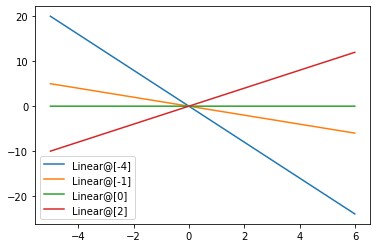

In [3]:
# PLot kernel machine functions

plot_step = .01
xpts = np.arange(-5.0, 6, plot_step).reshape(-1, 1)
prototypes = np.array([-4, -1, 0, 2]).reshape(-1, 1)

# Linear kernel
y = linear_kernel(prototypes, xpts) 
for i in range(len(prototypes)):
    label = "Linear@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.show()

In [4]:
class Kernel_Machine(object):
    def __init__(self, kernel, prototype_points, weights):
        """
        Args:
            kernel(X1,X2) - a function return the cross-kernel matrix between rows of X1 and rows of X2 for kernel k
            prototype_points - an R x d matrix with rows mu_1,...,mu_R
            weights - a vector of length R with entries w_1,...,w_R
        """

        self.kernel = kernel
        self.prototype_points = prototype_points
        self.weights = weights
        
    def predict(self, X):
        """
        Evaluates the kernel machine on the points given by the rows of X
        Args:
            X - an nxd matrix with inputs x_1,...,x_n in the rows
        Returns:
            Vector of kernel machine evaluations on the n points in X.  Specifically, jth entry of return vector is
                Sum_{i=1}^R w_i k(x_j, mu_i)
        """
        gram_mat = self.kernel(X, self.prototype_points)
        return np.dot(gram_mat, self.weights)


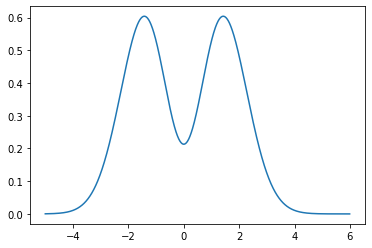

In [5]:
# A simple test for kernel machine.

test_kernel = functools.partial(RBF_kernel, sigma=1)
test_prototypes = np.asarray([-1, 0, 1]).reshape([-1, 1])
test_weights = np.asarray([1, -1, 1])
km = Kernel_Machine(test_kernel, test_prototypes, test_weights)
test_points = np.arange(-5, 6, 0.01).reshape([-1, 1])
func_collections = km.predict(test_points)
plt.plot(test_points, func_collections)
plt.show()

Load train & test data; Convert to column vectors, so it generalizes well to data in higher dimensions.

In [6]:
data_train, data_test = np.loadtxt("../data/hw4/krr-train.txt"), np.loadtxt("../data/hw4/krr-test.txt")
x_train, y_train = data_train[:, 0].reshape(-1, 1), data_train[:, 1].reshape(-1, 1)
x_test, y_test = data_test[:, 0].reshape(-1, 1), data_test[:, 1].reshape(-1, 1)

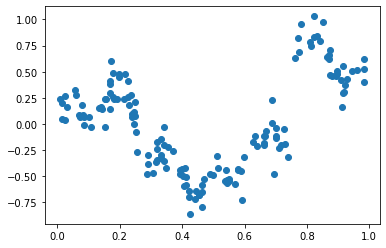

In [16]:
# Plot the relationship between x and y, which is highly non-linear.

plt.plot(np.concatenate([x_train, x_test]), np.concatenate([y_train, y_test]), 'o')
plt.show()

In [8]:

def train_kernel_ridge_regression(X, y, kernel, l2reg):
    num_ins = len(y)
    gram_mat = kernel(X, X)
    alpha = np.linalg.inv(l2reg*np.identity(num_ins) + gram_mat) @ y
    return Kernel_Machine(kernel, X, alpha)


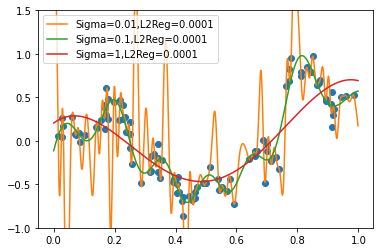

In [9]:
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1, 1)
plt.plot(x_train, y_train, 'o')
l2reg = 0.0001
for sigma in [.01, .1, 1]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc='best')
plt.ylim(-1, 1.5)
plt.show()

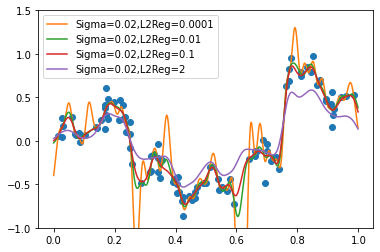

In [10]:
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1, 1)
plt.plot(x_train, y_train, 'o')
sigma= .02
for l2reg in [.0001, .01, .1, 2]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc='best')
plt.ylim(-1,1.5)
plt.show()

In [12]:
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin

class KernelRidgeRegression(BaseEstimator, RegressorMixin):
    """sklearn wrapper for our kernel ridge regression"""
     
    def __init__(self, kernel="RBF", sigma=1, degree=2, offset=1, l2reg=1):        
        self.kernel = kernel
        self.sigma = sigma
        self.degree = degree
        self.offset = offset
        self.l2reg = l2reg

    def fit(self, X, y=None):
        """
        This should fit classifier. All the "work" should be done here.
        """
        if (self.kernel == "linear"):
            self.k = linear_kernel
        elif (self.kernel == "RBF"):
            self.k = functools.partial(RBF_kernel, sigma=self.sigma)
        elif (self.kernel == "polynomial"):
            self.k = functools.partial(polynomial_kernel, offset=self.offset, degree=self.degree)
        else:
            raise ValueError('Unrecognized kernel type requested.')
        
        self.kernel_machine_ = train_kernel_ridge_regression(X, y, self.k, self.l2reg)

        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "kernel_machine_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return(self.kernel_machine_.predict(X))

    def score(self, X, y=None):
        # get the average square error
        return(((self.predict(X)-y)**2).mean()) 

In [34]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd
    
test_fold = [-1]*len(x_train) + [0]*len(x_test)   #0 corresponds to test, -1 to train
predefined_split = PredefinedSplit(test_fold=test_fold)

In [ ]:
param_grid = [{'kernel': ['RBF'],'sigma': [.1, 1, 10], 'l2reg': np.exp2(-np.arange(-5 , 5, 1))},
              {'kernel': ['polynomial'], 'offset': [-1, 0, 1], 'degree': [2, 3 , 4], 'l2reg': [10, .1, .01]},
              {'kernel': ['linear'], 'l2reg': [10, 1, .01]}]
kernel_ridge_regression_estimator = KernelRidgeRegression()
grid = GridSearchCV(kernel_ridge_regression_estimator, 
                    param_grid,
                    cv=predefined_split,
                    scoring=make_scorer(mean_squared_error, greater_is_better=False)
                  # n_jobs = -1  #should allow parallelism, but crashes Python on my machine
                   )
grid.fit(np.vstack((x_train, x_test)),np.vstack((y_train, y_test)))

In [ ]:
pd.set_option('display.max_rows', 20)
df = pd.DataFrame(grid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better=FALSE"
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
cols_to_keep = ["param_degree", "param_kernel", "param_l2reg" , "param_offset", "param_sigma",
        "mean_test_score", "mean_train_score"]
df_toshow = df[cols_to_keep].fillna('-')
df_toshow.sort_values(by=["mean_test_score"])

In [69]:
# Can be a more convenient way to look at the table
import qgrid

qgrid.show_grid(df_toshow)

In [ ]:
## Plot the best polynomial and RBF fits you found
plot_step = .01
xpts = np.arange(-.5 , 1.5, plot_step).reshape(-1, 1)
plt.plot(x_train,y_train, 'o')
#Plot best polynomial fit
offset= 1
degree = 1
l2reg = 1
k = functools.partial(polynomial_kernel, offset=offset, degree=degree)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "Offset="+str(offset)+",Degree="+str(degree)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)
#Plot best RBF fit
sigma = 1
l2reg= 1
k = functools.partial(RBF_kernel, sigma=sigma)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.75)
plt.show()

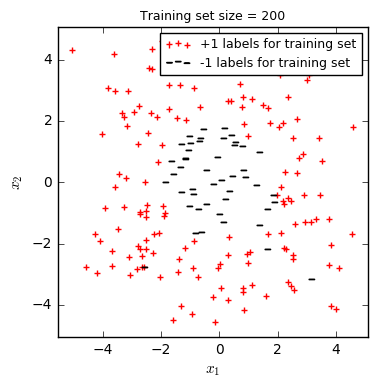

In [8]:
# Load and plot the SVM data
# Load the training and test sets

data_train, data_test = np.loadtxt("../data/hw4/svm-train.txt"), np.loadtxt("../data/hw4/svm-test.txt")
x_train, y_train = data_train[:, 0:2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0:2], data_test[:, 2].reshape(-1, 1)

# Determine predictions for the training set

yplus = np.ma.masked_where(y_train[:, 0] <= 0, y_train[:, 0])
xplus = x_train[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_train[:, 0] > 0, y_train[:, 0])
xminus = x_train[~np.array(yminus.mask)]

# Plot the predictions for the training set

figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 

pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='r', label = '+1 labels for training set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 labels for training set')

ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('Training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

In [ ]:
# Code to help plot the decision regions
# (Note: This ode isn't necessarily entirely appropriate for the questions asked. So think about what you are doing.)
 
sigma = 1
k = functools.partial(RBF_kernel, sigma=sigma)
f = train_soft_svm(x_train, y_train, k, ...)

#determine the decision regions for the predictions

x1_min = min(x_test[:,0])
x1_max = max(x_test[:,0])
x2_min = min(x_test[:,1])
x2_max = max(x_test[:,1])
h = 0.1
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h),
                     np.arange(x2_min, x2_max, h))

Z = f.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Determine the predictions for the test set

y_bar = f.predict(x_test)
yplus = np.ma.masked_where(y_bar<=0, y_bar)
xplus = x_test[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_bar>0, y_bar)
xminus = x_test[~np.array(yminus.mask)]

# Plot the learned boundary and the predictions for the test set

figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize)
decision =ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
pluses = ax.scatter(xplus[:,0], xplus[:,1], marker='+', c='b', label='+1 prediction for test set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label='-1 prediction for test set')
ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('SVM with RBF Kernel: training set size = %s'% len(data_train), fontsize=9)
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()